In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_all_params(df):
    """Initializes the variables containing the run names and the parameters dictionary for each run."""
    
    def get_run_params(run):
        result = {}
        params = df[df.type == "param"]
        for index, row in params[params.run == run].iterrows():
            # Convert numerical values to float
            try:
                result[row.attrname] = float(row.attrvalue)
            except ValueError:
                result[row.attrname] = row.attrvalue
        return result
    
    global all_params, all_runs
    
    all_params = {}
    all_runs = df.run.unique()
    for run in all_runs:       
        all_params[run] = get_run_params(run)

In [3]:
def find_runs(params={}):
    """Returns an array containing the run names with the parameters provided as a dictionary."""
    
    if params == {}:
        return all_runs.tolist()
    
    result = []
    
    for run in all_runs:       
        run_params = all_params[run]
        to_keep = True
                
        for name, value in params.items():
            if type(value) is str:
                check_value = '"'+value+'"'
            else:
                check_value = value
                
            if name not in run_params or run_params[name] != check_value:
                to_keep = False
                break
        if to_keep:      
            result.append(run)
                
    return result

In [4]:
def get_vecvalue(run, name):
    """Returns an array containing the values of a given vector for the specified run."""
    
    try:
        return np.fromstring(df[(df.type == "vector") & (df.run == run) & (df.name == name)].iloc[0].vecvalue, 
                             sep=" ", dtype=np.double)
    except Exception:
        return np.array([])


def get_vectime(run, name):
    """Returns an array containing the time values of a given vector for the specified run."""
    
    try:
        return np.fromstring(df[(df.type == "vector") & (df.run == run) & (df.name == name)].iloc[0].vectime, 
                             sep=" ", dtype=np.double)
    except Exception:
        return np.array([])

In [5]:
def get_throughput(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'Throughput:vector')


def get_throughput_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'Throughput:vector')


def get_rt(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'ResponseTime:vector')


def get_rt_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'ResponseTime:vector')


def get_num_plane(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'numPlane:vector')


def get_num_plane_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'numPlane:vector')

In [6]:
def get_param_values(param_name):
    
    param_values = set()
    for key in all_params.keys():
        param_values.add(all_params[key][param_name])
    
    return param_values


def get_combinations(*params):
    
    param_values = []
    
    for param in params:
        param_values.append(get_param_values(param))
        
    result = []
    combinations = itertools.product(*param_values)
    for item in combinations:
        combination = {}
        for idx, param in enumerate(params):
            combination[param] = item[idx]
        result.append(combination)
    
    return result

In [7]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_exponential.csv')
get_all_params(df)

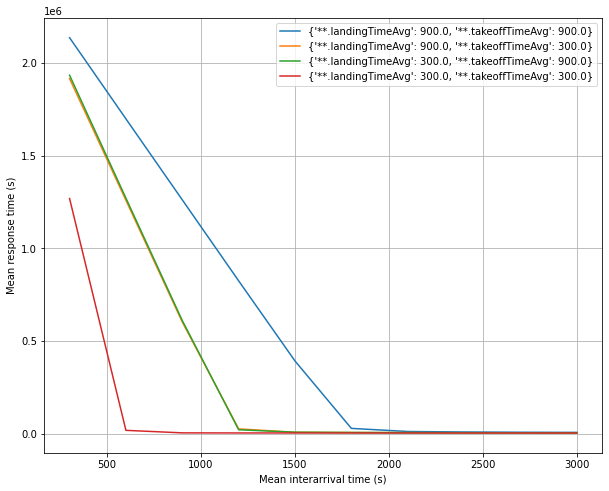

In [8]:
combinations = get_combinations('**.landingTimeAvg', '**.takeoffTimeAvg')
    
plt.figure(figsize=(10, 8))
for combination in combinations:
    runs = find_runs(combination)
    mean_rts = []
    mean_rt_iats = []
    for run in sorted(runs, key=lambda x: (all_params[x]['**.interarrivalTimeAvg'])):
        mean_rts.append(np.mean(get_rt(run)))
        mean_rt_iats.append(all_params[run]['**.interarrivalTimeAvg'])
    x = np.array(mean_rt_iats, dtype=int)
    y = np.array(mean_rts, dtype=float)
    plt.plot(x, y, label=str(combination))
plt.grid(True, 'both')
plt.xlabel("Mean interarrival time (s)")
plt.ylabel("Mean response time (s)")
plt.legend()
plt.savefig('../results/plots/calibration.pdf', bbox_inches='tight')